**Requirements**

Please note. We have supplied some examples of how students have previously done the preprocessing to give you some input and thus make the work load a bit less. Feel free to use/reuse the preprocessing steps of these solutions.

1. **Data preprocessing:** You must handle large datasets and perform necessary data preprocessing tasks. This includes dealing with missing values, handling outliers, and scaling data appropriately for the chosen regression technique. Feel free to use or get inspired by previous solutions.

    a. Consider the appropriate intervals for wind speeds and wind directions. No negative wind speeds are allowed, and wind directions should be in an appropriate interval (e.g. [0; 360[ degrees).

    b. Select which ws / wd signals to use. Signals at higher altitude are generally better, but it is even more important to have proper coverage of all seasons.

    c. Find the meso-signals closest in height to the mast-data-signal you are using. Or interpolate the values between 2 or more meso-signals to get the values at the exact mast-signal-height.

    d. Convert the mast data from DK time to UTC time (corresponding to the time zone used in the meso data). Remember to account for summer-time in DK.
    
    e. Resample the mast dataset to have the same frequency as the meso data. The meso data has one record for each hour, the mast data has one record for each 10 min.

        i. Note: You should not convert the ws / wd signals to vector-quantities and use those for the resampling. Resample the ws and wd signal individually instead. The turbines “yaw” to always point toward the incoming wind, so the interesting value is the wind speed and not the wind velocity.  
        ii. Be careful when resampling the wind directions. You don’t want the average of 0 degrees and 359 degrees to become ~180 degrees :-)

    f. Find the overlapping timestamps between the meso data and the resampled mast data. You only want to consider data in this overlapping time period in your training.

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import stats

In [2]:
#load the mast data
from datetime import datetime
file_path_risoe = 'Data/Risoe/risoe_m_all.nc'
dataset = nc.Dataset(file_path_risoe, 'r')
df_mast = pd.DataFrame({
    'time': dataset.variables['time'][:],
    'ws77': dataset.variables['ws77'][:],
    'wd77': dataset.variables['wd77'][:],
    'ws125': dataset.variables['ws125'][:],
    'wd125': dataset.variables['wd125'][:]
})
base_date = datetime(1995, 11, 20, 16, 25, 0)

#convert time to datetime format
df_mast['time'] = pd.to_datetime(df_mast['time'], unit='m', origin=base_date)
df_mast

,time,ws77,wd77,ws125,wd125
0,1995-11-20 16:25:00,3.36,205.0,3.04,208.0
1,1995-11-20 16:35:00,3.05,205.0,3.17,214.0
2,1995-11-20 16:45:00,3.59,204.0,3.64,209.0
3,1995-11-20 16:55:00,3.87,202.0,3.77,209.0
4,1995-11-20 17:05:00,4.74,201.0,4.28,212.0
...,...,...,...,...,...
628354,2007-12-31 23:16:00,6.04,0.0,NaN,0.0
628355,2007-12-31 23:26:00,6.97,0.0,NaN,0.0
628356,2007-12-31 23:36:00,8.17,0.0,NaN,0.0
628357,2007-12-31 23:46:00,6.66,0.0,NaN,0.0


In [3]:
# Define the season function
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_mast_with_season = df_mast.copy()
# Create the Season column
df_mast_with_season['Season'] = df_mast_with_season['time'].apply(get_season)

# Drop the time column
df_mast_with_season = df_mast_with_season.drop('time', axis=1)

# Group by season and count non-null values in your data column
df_mast_with_season = df_mast_with_season.groupby('Season').count()

print(df_mast_with_season)


          ws77    wd77   ws125   wd125
Season                                
Autumn  156303  156245  140901  144876
Spring  157746  157959  129813  130844
Summer  157938  157983  142994  149005
Winter  149620  155624  127997  134105


In [4]:
# Drop the columns with higher amount of missing values
df_mast = df_mast.drop(columns=['ws125', 'wd125'])

df_mast

,time,ws77,wd77
0,1995-11-20 16:25:00,3.36,205.0
1,1995-11-20 16:35:00,3.05,205.0
2,1995-11-20 16:45:00,3.59,204.0
3,1995-11-20 16:55:00,3.87,202.0
4,1995-11-20 17:05:00,4.74,201.0
...,...,...,...
628354,2007-12-31 23:16:00,6.04,0.0
628355,2007-12-31 23:26:00,6.97,0.0
628356,2007-12-31 23:36:00,8.17,0.0
628357,2007-12-31 23:46:00,6.66,0.0


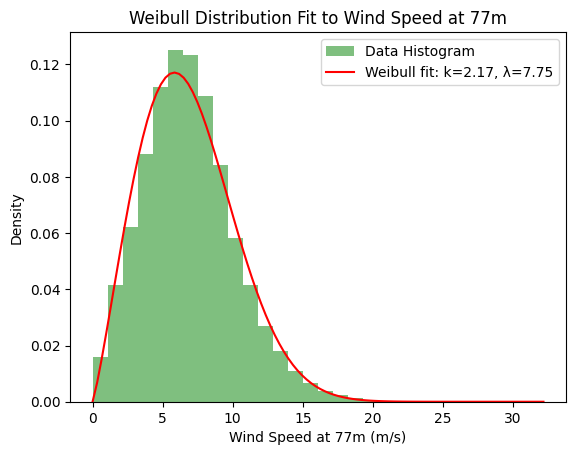

In [5]:
# The Weibull distribution of mast data

# Remove non-finite values (NaN, Inf, -Inf) from the dataset
wind_speeds_clean = df_mast['ws77'].replace([np.inf, -np.inf], np.nan).dropna()

# Fit the Weibull distribution to the cleaned data
shape, loc, scale = stats.weibull_min.fit(wind_speeds_clean, floc=0)

# Generate values for the fitted distribution
x = np.linspace(wind_speeds_clean.min(), wind_speeds_clean.max(), 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

# Plot the histogram and the PDF of the fitted Weibull distribution
plt.hist(wind_speeds_clean, bins=30, density=True, alpha=0.5, color='g', label='Data Histogram')
plt.plot(x, y, 'r-', label=f'Weibull fit: k={shape:.2f}, λ={scale:.2f}')

# Add labels and legend
plt.xlabel('Wind Speed at 77m (m/s)')
plt.ylabel('Density')
plt.title('Weibull Distribution Fit to Wind Speed at 77m')
plt.legend()

plt.show()

In [6]:
#Convert the mast data from DK time to UTC time (corresponding to the time zone used in the meso data). If the date is between Mar 26 and Oct 29, subtract 2 hours. Otherwise, subtract 1 hour.
df_mast['time'] = df_mast['time'].apply(lambda x: x - pd.DateOffset(hours=2) if x.month > 3 and x.month <= 11 else x - pd.DateOffset(hours=1))
df_mast

,time,ws77,wd77
0,1995-11-20 14:25:00,3.36,205.0
1,1995-11-20 14:35:00,3.05,205.0
2,1995-11-20 14:45:00,3.59,204.0
3,1995-11-20 14:55:00,3.87,202.0
4,1995-11-20 15:05:00,4.74,201.0
...,...,...,...
628354,2007-12-31 22:16:00,6.04,0.0
628355,2007-12-31 22:26:00,6.97,0.0
628356,2007-12-31 22:36:00,8.17,0.0
628357,2007-12-31 22:46:00,6.66,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628359 entries, 0 to 628358
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    628359 non-null  datetime64[ns]
 1   ws77    621607 non-null  float64       
 2   wd77    627811 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.4 MB


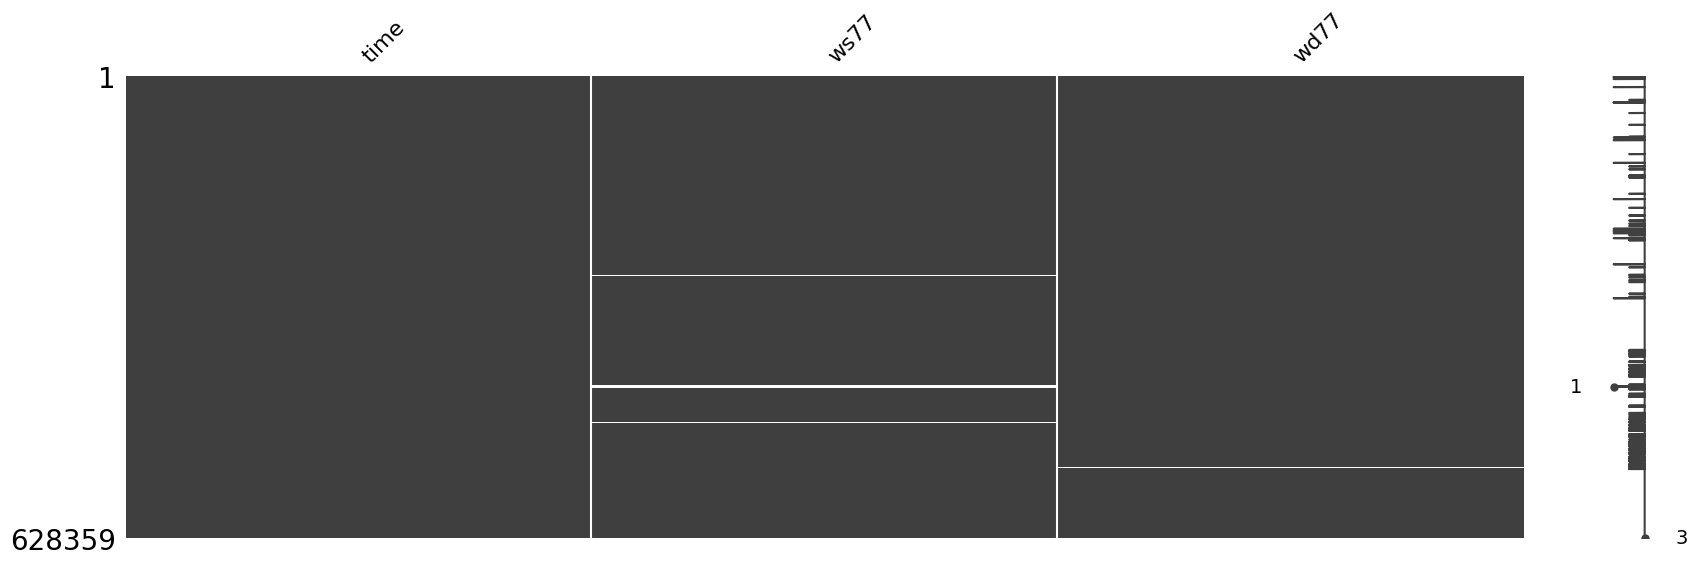

In [7]:
import missingno as mno

# Visualize the distribution of the missing values
df_mast.isnull().sum()
mno.matrix(df_mast, figsize = (20, 6))

df_mast.info()


In [8]:
#Resample the mast dataset to have the same frequency as the meso data. The meso data has one record for each hour, the mast data has one record for each 10 min.
import math

df_mast = df_mast.set_index('time')
df_mast = df_mast.dropna()
# Resample 'ws77' using mean
resampled_ws77 = df_mast['ws77'].resample('1h').mean()

# Define a custom aggregation function for 'wd77'
def circular_mean(values):
    radians = [val * (2 * math.pi / 360) for val in values]
    sines = [sum([math.sin(rad) for rad in radians])]
    cosines = [sum([math.cos(rad) for rad in radians])]
    mean_rad = math.atan2(sines[0], cosines[0])
    mean_deg = mean_rad * (360 / (2 * math.pi))
    return mean_deg if mean_deg >= 0 else mean_deg + 360

# Resample 'wd77' using the custom aggregation function
resampled_wd77 = df_mast['wd77'].resample('1h').apply(circular_mean)

# Combine the resampled data into a new DataFrame
resampled_mast = pd.DataFrame({'ws77': resampled_ws77, 'wd77': resampled_wd77})

resampled_mast

,ws77,wd77
time,,
1995-11-20 14:00:00,3.467500,204.000076
1995-11-20 15:00:00,5.216667,201.003152
1995-11-20 16:00:00,6.288333,202.833228
1995-11-20 17:00:00,7.316667,200.166908
1995-11-20 18:00:00,7.943333,197.500508
...,...,...
2007-12-31 18:00:00,6.366667,0.000000
2007-12-31 19:00:00,8.723333,0.000000
2007-12-31 20:00:00,8.430000,0.000000


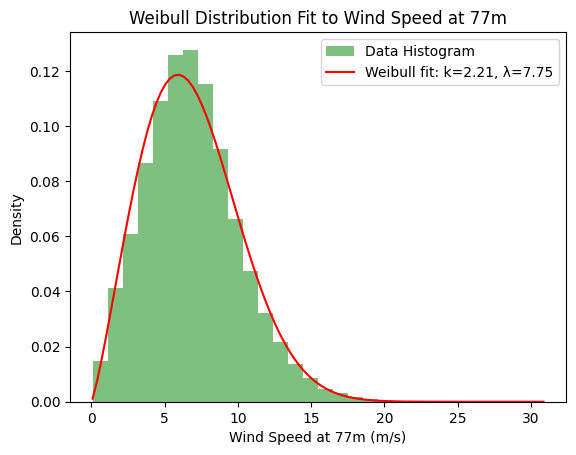

In [9]:
# The Weibull distribution of resampled mast data

# Remove non-finite values (NaN, Inf, -Inf) from the dataset
resampled_wind_speeds_clean = resampled_mast['ws77'].replace([np.inf, -np.inf], np.nan).dropna()

# Fit the Weibull distribution to the cleaned data
shape, loc, scale = stats.weibull_min.fit(resampled_wind_speeds_clean, floc=0)

# Generate values for the fitted distribution
x = np.linspace(resampled_wind_speeds_clean.min(), resampled_wind_speeds_clean.max(), 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

# Plot the histogram and the PDF of the fitted Weibull distribution
plt.hist(resampled_wind_speeds_clean, bins=30, density=True, alpha=0.5, color='g', label='Data Histogram')
plt.plot(x, y, 'r-', label=f'Weibull fit: k={shape:.2f}, λ={scale:.2f}')

# Add labels and legend
plt.xlabel('Wind Speed at 77m (m/s)')
plt.ylabel('Density')
plt.title('Weibull Distribution Fit to Wind Speed at 77m')
plt.legend()

plt.show()

In [10]:
# Remove inproper values in mast data

# Remove negative values in ws column
resampled_mast = resampled_mast[resampled_mast['ws77'] >= 0]

# Keep values only from 0 to 359 in wd column
resampled_mast = resampled_mast[resampled_mast['wd77'] >= 0] 
resampled_mast = resampled_mast[resampled_mast['wd77'] < 360] 

resampled_mast
resampled_mast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103640 entries, 1995-11-20 14:00:00 to 2007-12-31 22:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ws77    103640 non-null  float64
 1   wd77    103640 non-null  float64
dtypes: float64(2)
memory usage: 2.4 MB


In [11]:
# Load the meso data
filepath_meso = 'meso_Risoe.csv'
df_meso = pd.read_csv(filepath_meso)

# Leave only the TIMESTAMP, WSP080, WDIR080 columns
df_meso = df_meso[['TIMESTAMP', 'WSP080', 'WDIR080']]
df_meso['TIMESTAMP'] = pd.to_datetime(df_meso['TIMESTAMP'])
df_meso

FileNotFoundError: [Errno 2] No such file or directory: 'meso_Risoe.csv'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204288 entries, 0 to 204287
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   TIMESTAMP  204288 non-null  datetime64[ns]
 1   WSP080     204288 non-null  float64       
 2   WDIR080    204288 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.7 MB


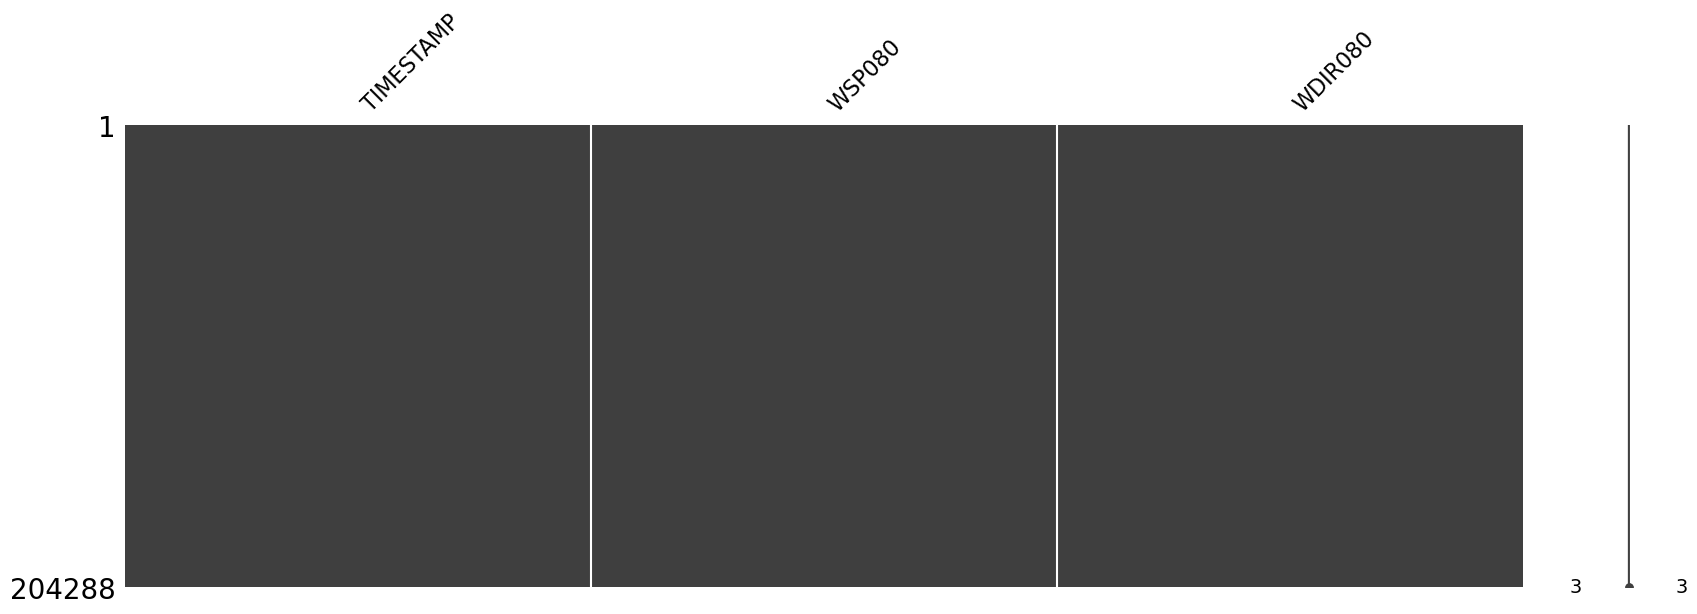

In [ ]:
# Visualize the distribution of the missing values in the meso data
df_meso.isnull().sum()
mno.matrix(df_meso, figsize = (20, 6))

df_meso.info()

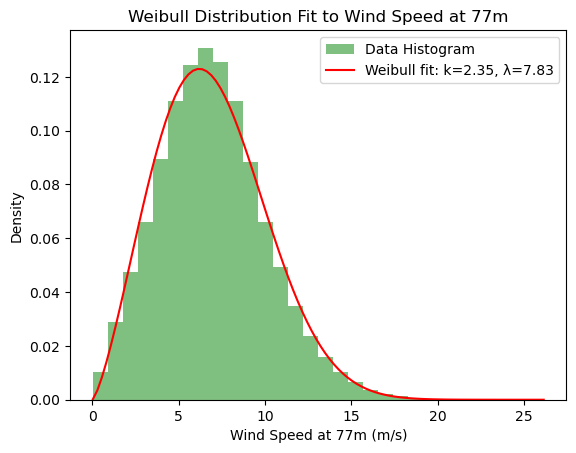

In [ ]:
# The Weibull distribution of meso data
wind_speeds_meso = df_meso['WSP080']

# Fit the Weibull distribution to the cleaned data
shape, loc, scale = stats.weibull_min.fit(wind_speeds_meso, floc=0)

# Generate values for the fitted distribution
x = np.linspace(wind_speeds_meso.min(), wind_speeds_meso.max(), 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

# Plot the histogram and the PDF of the fitted Weibull distribution
plt.hist(wind_speeds_meso, bins=30, density=True, alpha=0.5, color='g', label='Data Histogram')
plt.plot(x, y, 'r-', label=f'Weibull fit: k={shape:.2f}, λ={scale:.2f}')

# Add labels and legend
plt.xlabel('Wind Speed at 77m (m/s)')
plt.ylabel('Density')
plt.title('Weibull Distribution Fit to Wind Speed at 77m')
plt.legend()

plt.show()

In [ ]:
# Join the datasets on an overlapping time period
df_joined = resampled_mast.join(df_meso.set_index('TIMESTAMP'), how='inner')
df_joined

,ws77,wd77,WSP080,WDIR080
2000-01-01 07:00:00,6.573333,183.502033,5.83,209.09
2000-01-01 08:00:00,6.203333,194.212940,6.13,204.21
2000-01-01 09:00:00,6.701667,201.995414,6.69,204.75
2000-01-01 10:00:00,7.120000,196.499314,6.37,211.50
2000-01-01 11:00:00,6.541667,201.003968,6.20,217.37
...,...,...,...,...
2007-12-31 18:00:00,6.366667,0.000000,6.43,11.71
2007-12-31 19:00:00,8.723333,0.000000,5.18,12.00
2007-12-31 20:00:00,8.430000,0.000000,4.98,6.64
2007-12-31 21:00:00,8.136667,0.000000,6.37,3.34


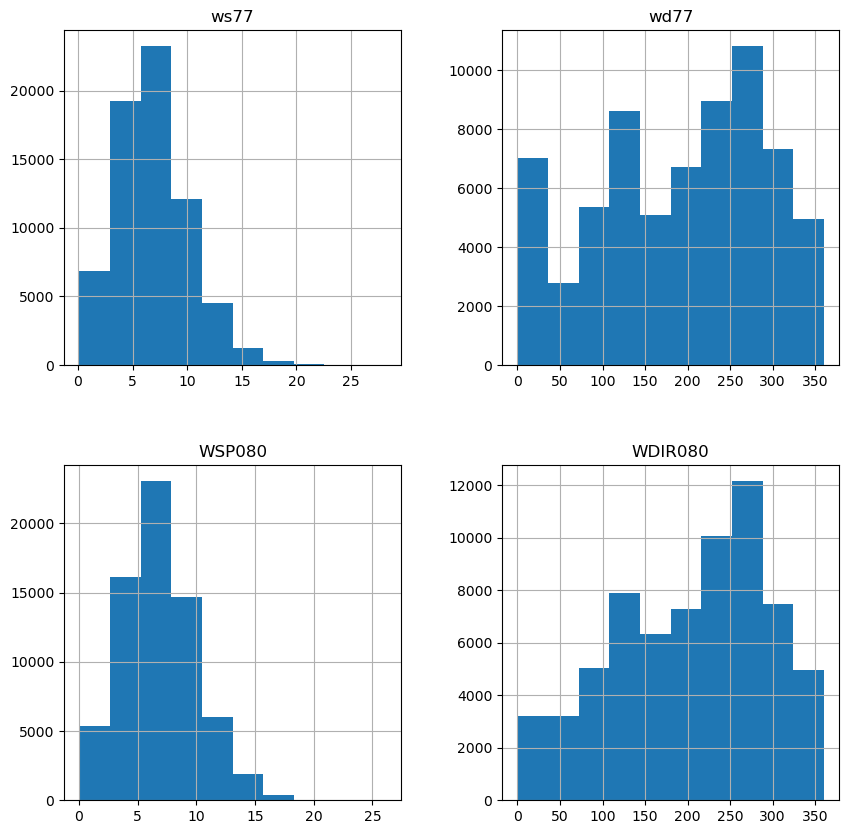

In [ ]:
df_joined.hist(figsize=(10,10))
plt.show()

In [ ]:
# Add the time column from index
df_joined['time'] = df_joined.index

# Use timestamp to develop "season" category column for further analysis
df_joined['season'] = df_joined['time'].dt.month
# Replac the winter months with 1, spring with 2, summer with 3 and autumn with 4
df_joined['season'] = df_joined['season'].replace([1,2,3,4,5,6,7,8,9,10,11,12],[1,1,2,2,2,3,3,3,4,4,4,1])

# This can be done with hot encoder but we decided to go with previous method to have a parameter to stratify the data while splitting to train and test
# df_joined['spring'] = df_joined['time'].dt.month.between(3, 5, inclusive='both').astype(int)
# df_joined['summer'] = df_joined['time'].dt.month.between(6, 8, inclusive='both').astype(int)
# df_joined['fall'] = df_joined['time'].dt.month.between(9, 11, inclusive='both').astype(int)
# df_joined['winter'] = ((df_joined['time'].dt.month >= 12) | (df_joined['time'].dt.month <= 2)).astype(int)

# Drop the time column and missing values
df_joined = df_joined.drop(columns=['time'])
df_joined = df_joined.dropna()
df_joined.head()

,ws77,wd77,WSP080,WDIR080,season
2000-01-01 07:00:00,6.573333,183.502033,5.83,209.09,1
2000-01-01 08:00:00,6.203333,194.212940,6.13,204.21,1
2000-01-01 09:00:00,6.701667,201.995414,6.69,204.75,1
2000-01-01 10:00:00,7.120000,196.499314,6.37,211.50,1
2000-01-01 11:00:00,6.541667,201.003968,6.20,217.37,1


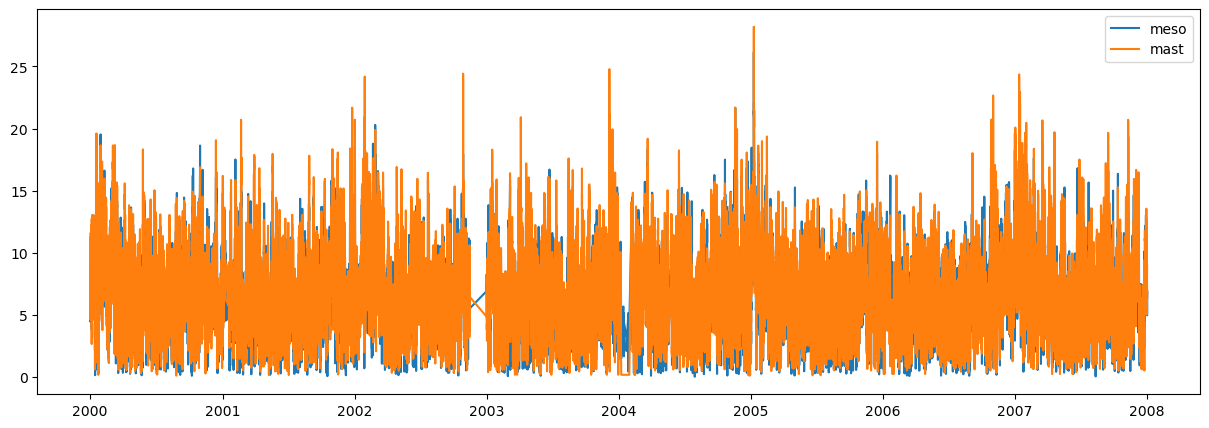

In [ ]:
# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(df_joined['WSP080'], label='meso')
plt.plot(df_joined['ws77'], label='mast')
plt.legend()
plt.show()

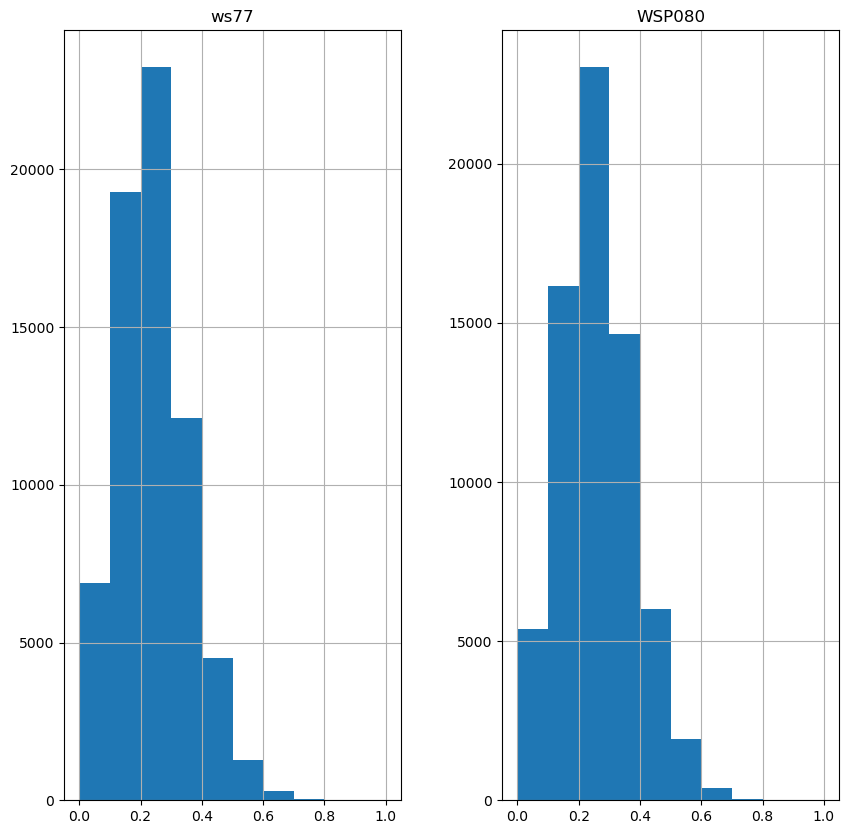

,ws77,WSP080,season,wd77_sin,wd77_cos,WDIR080_sin,WDIR080_cos
2000-01-01 07:00:00,0.229723,0.221924,1,-0.061084,-0.998133,-0.486183,-0.873857
2000-01-01 08:00:00,0.216531,0.233423,1,-0.245526,-0.969390,-0.410082,-0.912049
2000-01-01 09:00:00,0.234298,0.254887,1,-0.374532,-0.927214,-0.418660,-0.908143
2000-01-01 10:00:00,0.249213,0.242622,1,-0.284004,-0.958823,-0.522499,-0.852640
2000-01-01 11:00:00,0.228593,0.236106,1,-0.358433,-0.933556,-0.606960,-0.794733


In [ ]:
# Scale the wind speed data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_joined['ws77'] = scaler.fit_transform(df_joined[['ws77']])
df_joined['WSP080'] = scaler.fit_transform(df_joined[['WSP080']])

df_joined[['ws77', 'WSP080']].hist(figsize=(10,10))
plt.show()

# Convert wind direction to two components using sine and cosine transformations to preserve the circular nature
df_joined['wd77_sin'] = np.sin(np.radians(df_joined['wd77']))
df_joined['wd77_cos'] = np.cos(np.radians(df_joined['wd77']))

df_joined['WDIR080_sin'] = np.sin(np.radians(df_joined['WDIR080']))
df_joined['WDIR080_cos'] = np.cos(np.radians(df_joined['WDIR080']))

df_scaled = df_joined.drop(columns=['wd77', 'WDIR080'])
df_scaled.head()

In [ ]:
# Dividing dataframe into train, verification and test datasets

from sklearn.model_selection import train_test_split

mast_speed = df_scaled['ws77']
mast_dir_sin = df_scaled['wd77_sin']
mast_dir_cos = df_scaled['wd77_cos']
meso_data = df_scaled.drop(columns=['ws77', 'wd77_sin', 'wd77_cos'])

X_train_speed, X_test_speed, y_train_speed, y_test_speed = train_test_split(meso_data, mast_speed, stratify=df_scaled['season'], random_state = 42)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# Ordinary least squares regression (OLS)

ols = LinearRegression()
ols.fit(X_train_speed, y_train_speed)

print("r^2 on train data is {}".format(ols.score(X_train_speed, y_train_speed)))
print("r^2 on test data is {}".format(ols.score(X_test_speed, y_test_speed)))
y_pred_ols = ols.predict(X_test_speed)
mse_linear_val = mean_squared_error(y_test_speed, y_pred_ols)
print("MSE on validation set:", mse_linear_val)

r^2 on train data is 0.7274135420189123
r^2 on test data is 0.7181041522384868
MSE on validation set: 0.003704555064620076


Intercept: 0.030436689959149388


Text(0, 0.5, 'Feature')

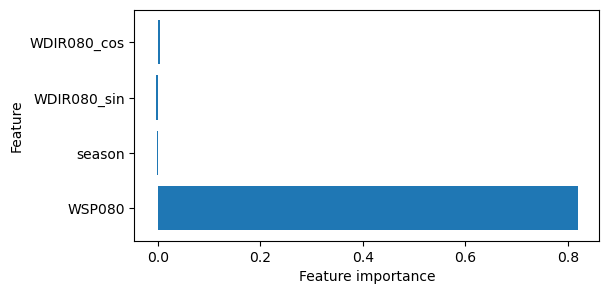

In [ ]:
print("Intercept: {}".format(ols.intercept_))

n_features = len(ols.coef_)
plt.figure(figsize=(6, 3), dpi = 100)
plt.barh(range(n_features), ols.coef_, align='center')
plt.yticks(np.arange(n_features), meso_data.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

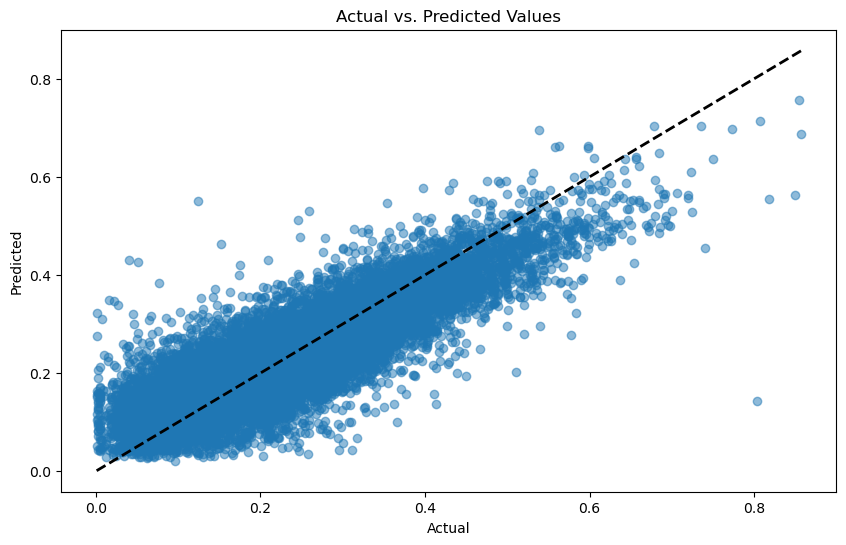

In [ ]:
import matplotlib.pyplot as plt

# Predictions
y_pred_val = ols.predict(X_test_speed)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_speed, y_pred_val, alpha=0.5)
plt.plot([y_test_speed.min(), y_test_speed.max()], [y_test_speed.min(), y_test_speed.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

Weibull distribution for predicted data

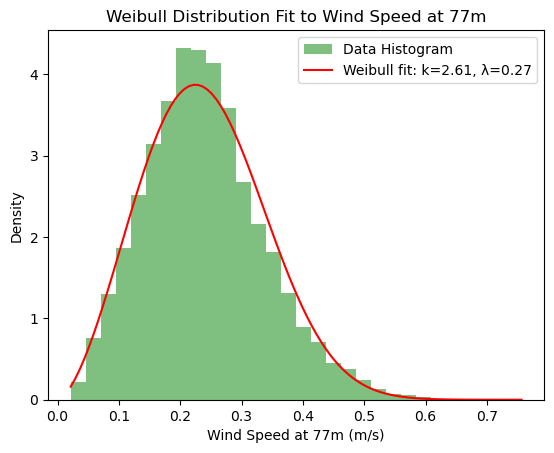

In [ ]:
y_pred_all_val = ols.predict(meso_data)

shape, loc, scale = stats.weibull_min.fit(y_pred_all_val, floc=0)

# Generate values for the fitted distribution
x = np.linspace(y_pred_val.min(), y_pred_val.max(), 100)
y = stats.weibull_min.pdf(x, shape, loc, scale)

# Plot the histogram and the PDF of the fitted Weibull distribution
plt.hist(y_pred_val, bins=30, density=True, alpha=0.5, color='g', label='Data Histogram')
plt.plot(x, y, 'r-', label=f'Weibull fit: k={shape:.2f}, λ={scale:.2f}')

# Add labels and legend
plt.xlabel('Wind Speed at 77m (m/s)')
plt.ylabel('Density')
plt.title('Weibull Distribution Fit to Wind Speed at 77m')
plt.legend()

plt.show()

### Lasso on wind speed


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

# Determine the optimal value of the regularization param (alpha)
alphas = 10**np.linspace(10,-2,100)*0.5

lassocv = LassoCV(alphas = alphas, max_iter = 100000)
lassocv.fit(X_train_speed, y_train_speed)
lassocv.alpha_

0.005

In [ ]:
lasso = Lasso(alpha = lassocv.alpha_, max_iter = 100000)
lasso.fit(X_train_speed, y_train_speed)
print("r^2 on train data is {}".format(lasso.score(X_train_speed, y_train_speed)))
print("r^2 on test data is {}".format(lasso.score(X_test_speed, y_test_speed)))
y_pred_speed_lasso = lasso.predict(X_test_speed)
mse_linear_val_speed_lasso = mean_squared_error(y_test_speed, y_pred_speed_lasso)
print("MSE on validation set:", mse_linear_val_speed_lasso)

# wihout Lasso
# r^2 on train data is 0.7284835995856447
# r^2 on test data is 0.7240603674307802
# MSE on validation set: 0.28110942320419957
# it s almost the same

r^2 on train data is 0.5925877989516982
r^2 on test data is 0.5876683213529412
MSE on validation set: 0.005418687151885771


Intercept: 0.11914770778792572


Text(0, 0.5, 'Feature')

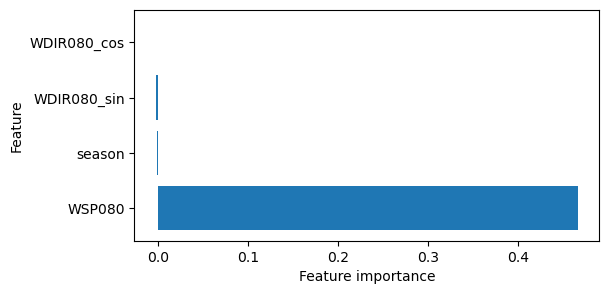

In [ ]:
print("Intercept: {}".format(lasso.intercept_))

n_features = len(lasso.coef_)
plt.figure(figsize=(6, 3), dpi = 100)
plt.barh(range(n_features), lasso.coef_, align='center')
plt.yticks(np.arange(n_features), meso_data.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

# same

### Ridge on wind speed

In [ ]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_speed, y_train_speed)
ridgecv.alpha_

0.006609705742330144

In [ ]:
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train_speed, y_train_speed)
print("r^2 on train data is {}".format(ridge.score(X_train_speed, y_train_speed)))
print("r^2 on test data is {}".format(ridge.score(X_test_speed, y_test_speed)))
y_pred_speed_ridge = ridge.predict(X_test_speed)
mse_linear_val_speed_ridge = mean_squared_error(y_test_speed, y_pred_speed_ridge)
print("MSE on validation set:", mse_linear_val_speed_ridge)


r^2 on train data is 0.7274135419550518
r^2 on test data is 0.7181042468268475
MSE on validation set: 0.003704553821580159


### Polynomial Regression on wind speed

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Define polynomial degree
degree = 4  # You can adjust the degree as needed

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create pipeline for polynomial regression
poly_regression = make_pipeline(poly_features, LinearRegression())

# Train polynomial regression model
poly_regression.fit(X_train_speed, y_train_speed)

# Predictions on validation set
y_pred_poly = poly_regression.predict(X_test_speed)

# Evaluation metrics on validation set
mse_poly_val = mean_squared_error(y_test_speed, y_pred_poly)
r2_poly_val = r2_score(y_test_speed, y_pred_poly)

# Print results
print("Polynomial Regression (Degree {}):".format(degree))
print("MSE on validation set:", mse_poly_val)
print("R-squared on test set:", r2_poly_val)

Polynomial Regression (Degree 4):
MSE on validation set: 0.003395344100827586
R-squared on test set: 0.7416333710663834


    OLS results:
    - r^2 on train data is 0.7274135420189123
    - r^2 on test data is 0.7181041522384868
    - MSE on validation set: 0.003704555064620076

    Lasso results:
    - r^2 on train data is 0.7283443455728362
    - r^2 on test data is 0.7241164939746016
    - MSE on validation set: 0.005418687151885771

    Ridge results:
    - r^2 on train data is 0.7274135419550518
    - r^2 on test data is 0.7181042468268475
    - MSE on validation set: 0.003704553821580159

    Polynomial results:
    - r^2 on test data set: 0.7416333710663834
    - MSE on validation set: 0.003395344100827586

Based on this we can conclude that OLS and Ridge performed better than other two. OLS is slightly better than Ridge so we will use it for predicting the wind direction. 
For our dataset Ridge, Lasso and Polynomial regression did not improved the regression model. 

### OLS on wind direction sinus

In [ ]:
X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(meso_data, mast_dir_sin, stratify=df_scaled['season'], random_state = 42)

# Ordinary least squares regression (OLS)
ols.fit(X_train_sin, y_train_sin)

print("r^2 on train data is {}".format(ols.score(X_train_sin, y_train_sin)))
print("r^2 on test data is {}".format(ols.score(X_test_sin, y_test_sin)))
y_pred_sin = ols.predict(X_test_sin)
mse_linear_val_sin = mean_squared_error(y_test_sin, y_pred_sin)
print("MSE on validation set:", mse_linear_val_sin)

r^2 on train data is 0.7483741945569085
r^2 on test data is 0.7374541025784482
MSE on validation set: 0.13492565838211215


### OLS on wind direction cosinus

In [ ]:
X_train_cos, X_test_cos, y_train_cos, y_test_cos = train_test_split(meso_data, mast_dir_cos, stratify=df_scaled['season'], random_state = 42)

# Ordinary least squares regression (OLS)
ols.fit(X_train_cos, y_train_cos)

print("r^2 on train data is {}".format(ols.score(X_train_cos, y_train_cos)))
print("r^2 on test data is {}".format(ols.score(X_test_cos, y_test_cos)))
y_pred_cos = ols.predict(X_test_cos)
mse_linear_val_cos = mean_squared_error(y_test_cos, y_pred_cos)
print("MSE on validation set:", mse_linear_val_cos)

r^2 on train data is 0.590005646673402
r^2 on test data is 0.5884448790817032
MSE on validation set: 0.1886780650423065
